In [12]:
import yt
from matplotlib import rc_context
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib
unit_base={"length_unit": (1e18,"cm"), "time_unit": (1e10,"s"), "mass_unit": (1e26,"g")}

In [33]:
ds = yt.load("first.athdf", units_override=unit_base, unit_system="cgs") # unit_system='cgs' is crucial
print(ds.length_unit, ds.time_unit, ds.mass_unit)
ds.unit_system

yt : [WARNING  ] 2025-01-26 16:15:40,634 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2025-01-26 16:15:40,634 Overriding length_unit: 1e+18 cm.
yt : [INFO     ] 2025-01-26 16:15:40,635 Overriding time_unit: 10000000000.0 s.
yt : [INFO     ] 2025-01-26 16:15:40,635 Overriding mass_unit: 1e+26 g.
yt : [WARNING  ] 2025-01-26 16:15:40,636 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2025-01-26 16:15:40,660 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-01-26 16:15:40,661 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2025-01-26 16:15:40,661 Parameters: domain_left_edge          = [-36. -18. -18.]
yt : [INFO     ] 2025-01-26 16:15:40,661 Parameters: domain_right_edge         = [36. 18. 18.]
yt : [INFO     ] 2025-01-26 16:15:40,662 Parameters: cosmological_simulation   = 0


1e+18 cm 10000000000.0 s 1e+26 g


cgs Unit System
 Base Units:
  length: cm
  mass: g
  time: s
  temperature: K
  angle: rad
  luminous_intensity: cd
  logarithmic: Np
 Other Units:
  energy: erg
  specific_energy: erg/g
  pressure: dyn/cm**2
  force: dyn
  magnetic_field_cgs: G
  charge_cgs: statC
  current_cgs: statA
  power: erg/s

yt : [INFO     ] 2025-01-26 16:21:25,444 Projection completed
yt : [INFO     ] 2025-01-26 16:21:25,446 xlim = -36.000000 36.000000
yt : [INFO     ] 2025-01-26 16:21:25,446 ylim = -18.000000 18.000000
yt : [INFO     ] 2025-01-26 16:21:25,449 xlim = -36.000000 36.000000
yt : [INFO     ] 2025-01-26 16:21:25,449 ylim = -18.000000 18.000000
yt : [INFO     ] 2025-01-26 16:21:25,450 Making a fixed resolution buffer of (('gas', 'temperature')) 512 by 256



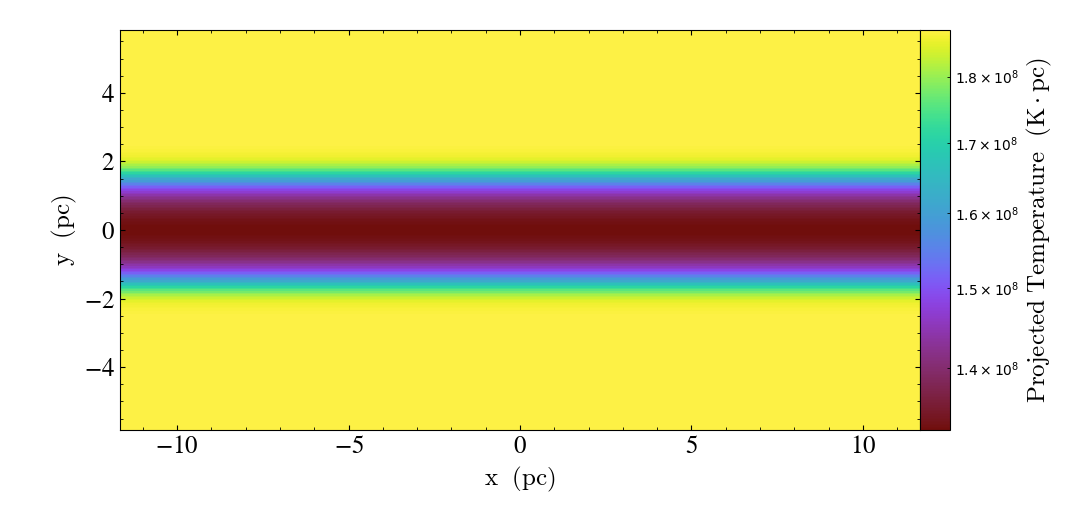

In [41]:
plot = yt.ProjectionPlot(ds, 'z', ('gas', 'temperature'), center='c', buff_size=(512, 256))
# plot.set_width((100, 'kpc'))
# yt.ProjectionPlot(ds, 'z', ('athena_pp', 'rho'))
# plot.set_log(('athena_pp', 'vel2'), False)
plot.set_unit(('gas', 'temperature'), 'K*pc')
plot.show()

In [64]:
frb = ds.r[::512j, ::256j, 0]
data = frb['temperature']
# data = data.reshape(*data.shape[::-1], 1)
print(np.max(data), np.min(data), np.max(data) / np.min(data))

16060994.396308925 code_temperature 161090.7879940367 code_temperature 99.70150743134656 dimensionless


In [65]:
first = yt.load('first.athdf', units_override=unit_base)
last = yt.load('last.athdf', units_override=unit_base)

# Calculates total internal energy and kinetic energy
def calc_energy(ds):
    data = ds.all_data()
    u = data['athena_pp', 'press']/(5/3-1)
    ke = 0.5 * (data['athena_pp', 'vel1']**2 + data['athena_pp', 'vel2']**2 + data['athena_pp', 'vel3']**2) * data['athena_pp', 'rho']
    return np.sum(u), np.sum(ke)
energy_first = calc_energy(first)
energy_last = calc_energy(last)
# Print in scientific notation
print(f'First-> Thermal:{energy_first[0].v:.2e} Kinetic:{energy_first[1].v:.2e} Total:{energy_first[0].v+energy_first[1].v:.2e}')
print(f'Last-> Thermal:{energy_last[0].v:.2e} Kinetic:{energy_last[1].v:.2e} Total:{energy_last[0].v+energy_last[1].v:.2e}')


yt : [WARNING  ] 2024-11-15 12:05:37,988 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-11-15 12:05:37,989 Overriding length_unit: 1e+18 cm.
yt : [INFO     ] 2024-11-15 12:05:37,989 Overriding time_unit: 10000000000.0 s.
yt : [INFO     ] 2024-11-15 12:05:37,990 Overriding mass_unit: 1e+26 g.
yt : [WARNING  ] 2024-11-15 12:05:37,990 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-11-15 12:05:38,016 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_left_edge          = [-36. -18. -18.]
yt : [INFO     ] 2024-11-15 12:05:38,017 Parameters: domain_right_edge         = [36. 18. 18.]
yt : [INFO     ] 2024-11-15 12:05:38,018 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-11-15 12:05:38,026 Overriding code units: Use this option only if you kno

First-> Thermal:2.20e+07 Kinetic:4.50e+07 Total:6.70e+07
Last-> Thermal:2.91e+07 Kinetic:3.79e+07 Total:6.70e+07


In [3]:
slc = ds.slice('z', 0)
slc['athena_pp', 'rho'].d
plt.imshow(slc['athena_pp', 'rho'].d.reshape(1024, 2048))
plt.show()
plt.imshow(frb['athena_pp', 'rho'].d)
plt.show()
print(slc.get_data(fields=('athena_pp', 'rho')))
# frb['density'].d.shape

2024-10-12 19:46:47.703 python[43521:3607665] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-12 19:46:47.703 python[43521:3607665] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


NameError: name 'frb' is not defined

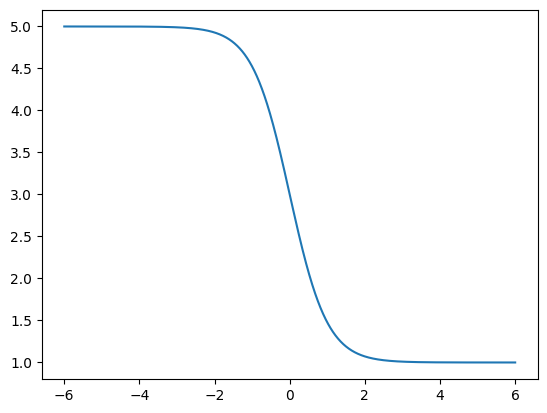

In [63]:
x = np.linspace(-6, 6, 2048)
contrast = 5
plt.plot(x, -np.tanh(x) * ((contrast-1) / 2) + ((contrast - 1) / 2 + 1) )

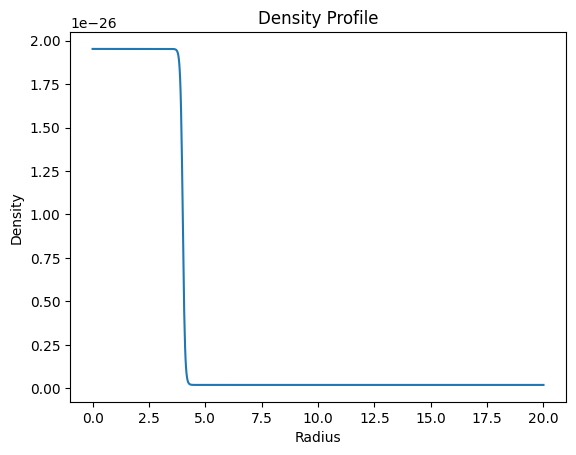

np.float64(1.952456891178e-26)

In [79]:
n_e = 1.e-4
mu_e = 1.166667
m_H = 1.673534e-24
rho_0 = n_e * mu_e * m_H
density_contrast = 100
smoothing_thickness = 0.1
# rho_0 = 1e-24
r = np.linspace(0, 20, 1000)
radius = 4

def density(r):
    # return rho_0 * (-np.tanh((r-radius)/smoothing_thickness) * ((density_contrast-1) / 2) + ((density_contrast - 1) / 2 + 1) )
    return rho_0 * ((density_contrast / 2) + 0.5 +
                                 (density_contrast - 1.0) * 0.5 * -np.tanh((r - radius) / smoothing_thickness))

plt.title("Density Profile")
plt.xlabel("Radius")
plt.ylabel("Density")
plt.plot(r, density(r))
# plt.ylim(1e-28, 1e-25)
plt.show() 
density(0) / density(20)
density(0)

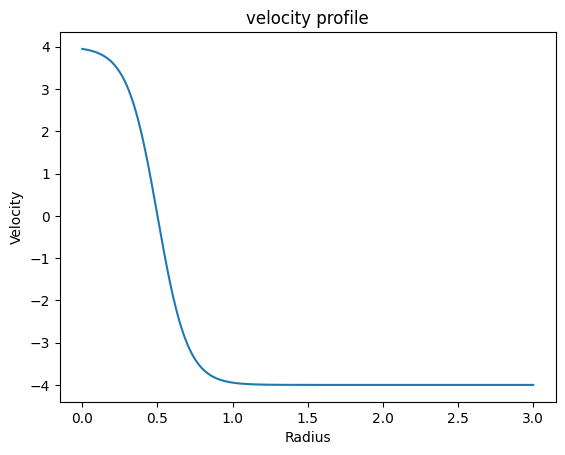

In [15]:
vel_shear = 4
smoothing_thickness_vel = 0.2

def velocity(r):
    return vel_shear * -1 * (np.tanh((r-radius)/smoothing_thickness_vel) )


plt.title("velocity profile")
plt.xlabel("Radius")
plt.ylabel("Velocity")
plt.plot(r, velocity(r))

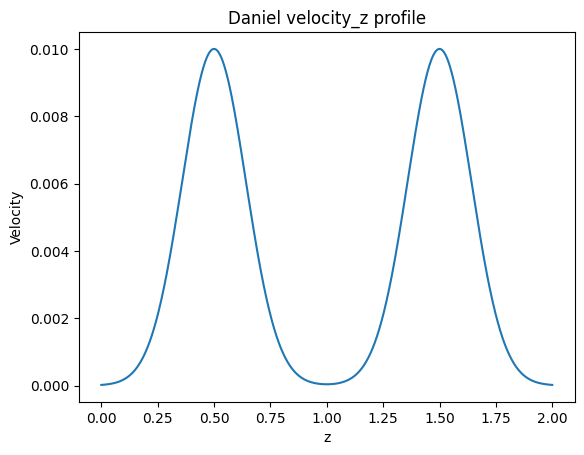

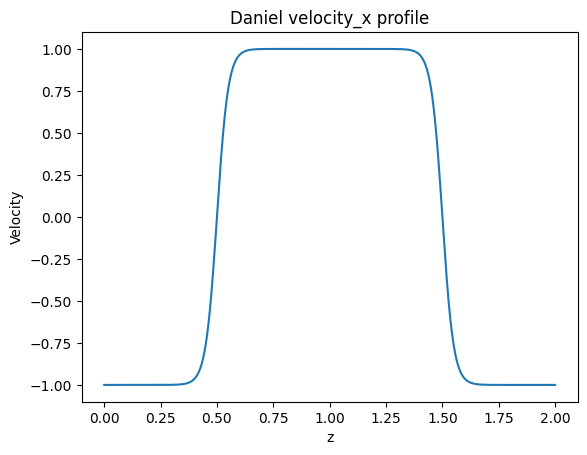

In [5]:
z = np.linspace(0, 2, 1000)
z1 = 0.5
z2 = 1.5
A = 0.01
x = 0.25
pert = A*np.sin(2*np.pi*x)
sigma = 0.2
a = 0.05
u_flow = 1

def vel_x(z):
    return u_flow * (np.tanh((z-z1)/a) - np.tanh((z-z2)/a) - 1)

def vel_z(z):
    return pert * (np.exp(-((z-z1)/sigma)**2)+np.exp(-((z-z2)/sigma)**2))

plt.title("Daniel velocity_z profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_z(z))
plt.show()

plt.title("Daniel velocity_x profile")
plt.xlabel("z")
plt.ylabel("Velocity")
plt.plot(z, vel_x(z))
plt.show()

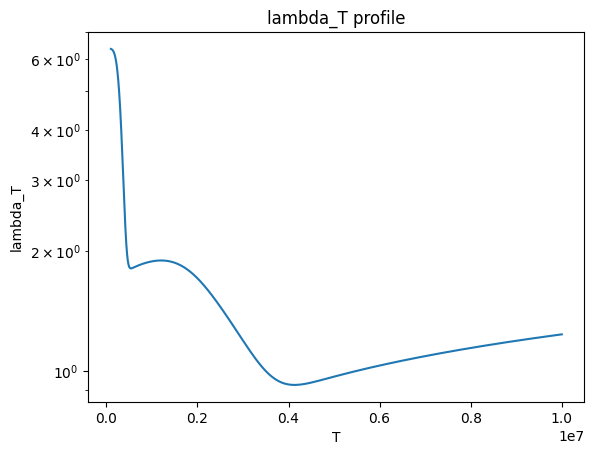

In [2]:
T_cold = 0.1
T_hot = 10
T = np.linspace(1e5, 1e7, 10000)
def Lambda_cool(temperature):
    Lambda = 4.7 * np.exp(-1 * np.pow(temperature / 3.5e5, 4.5))
    Lambda += 0.313 * np.pow(temperature, 0.08) * np.exp(-1 * np.pow(temperature / 3e6, 4.4))
    Lambda += 6.42 * np.pow(temperature, -0.2) * np.exp(-1 * np.pow(temperature / 2.1e6, 4.4))
    Lambda += 0.00439 * np.pow(temperature, 0.35)
    # Lambda *= 1e-22 
    return Lambda

plt.title("lambda_T profile")
plt.xlabel("T")
plt.ylabel("lambda_T")
plt.plot(T, Lambda_cool(T))
plt.yscale('log')
plt.show()
# lambda_T(0.1)

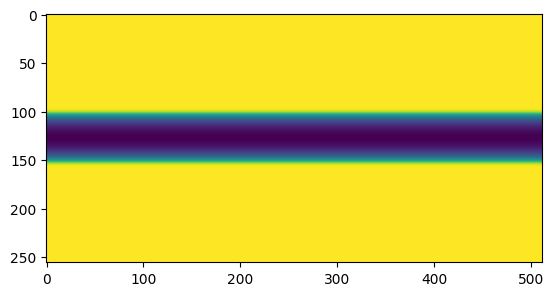

578195798.2671205 460847721.4185448


In [6]:
frame = np.load("../kh_updated/kh_custom.out1.00000.athdf.npy")
plt.imshow(frame)
plt.show()
print(np.max(frame), np.min(frame))